## Task 0: Downloading and subsampling the data

In [1]:
!pip install category_encoders pygeohash

In [2]:
# Arrange imports at the top
import itertools

import category_encoders     as ce
import matplotlib.pyplot     as plt
import missingno             as msno
import numpy                 as np
import pandas                as pd
import pygeohash             as geo
import seaborn               as sns

from collections             import Counter
from sklearn.compose         import make_column_transformer
from sklearn.impute          import (MissingIndicator,
                                     SimpleImputer)
from sklearn.linear_model    import (LinearRegression,
                                     Ridge,
                                     RidgeCV)
from sklearn.model_selection import (train_test_split,
                                     cross_validate)
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import (OneHotEncoder,
                                     OrdinalEncoder,
                                     PolynomialFeatures,
                                     StandardScaler)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# set a random seed for reproducibility
np.random.seed(42)

In [4]:
# Download the zipped dataset from a public bucket.
!wget https://storage.googleapis.com/aml-hw3-storage/craigslist-carstrucks-data.zip

--2020-04-20 08:46:05--  https://storage.googleapis.com/aml-hw3-storage/craigslist-carstrucks-data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360298489 (344M) [application/zip]
Saving to: ‘craigslist-carstrucks-data.zip.7’

craigslist-carstruc 100%[===================>] 343.61M   114MB/s    in 3.0s    

2020-04-20 08:46:08 (114 MB/s) - ‘craigslist-carstrucks-data.zip.7’ saved [360298489/360298489]



In [5]:
# Read and subsample the data
df = pd.read_csv('craigslist-carstrucks-data.zip')
sampled_df = df.sample(frac=0.12)
sampled_df.shape

(64771, 25)

## Task 1: Identify Features

####Split dataframe into two parts

In [6]:
# Check column names
sampled_df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [0]:
def split_into_x_and_y(df):
    """
    Utility to split df into X and y
    """
    X = df.loc[:, df.columns != 'price']
    y = df.loc[:, df.columns == 'price']
    return X, y

X, y = split_into_x_and_y(sampled_df)

In [8]:
# Sanity check of X and y's columns
print (X.columns)
print (y.columns)

Index(['id', 'url', 'region', 'region_url', 'year', 'manufacturer', 'model',
       'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')
Index(['price'], dtype='object')


#### Create a hold-out set

In [0]:
def get_train_test_split(X, y, df=None):
    """
    Utility to create a train test split with a fixed random seed.
    """
    if df is not None:
        X_df, y_df = split_into_x_and_y(df)
    else:
        X_df, y_df = X, y
    return train_test_split(X_df, y_df, test_size=0.2, random_state=42)

X_viz_df, y_viz_df = X.copy(deep=True), y.copy(deep=True)
X_viz, X_viz_test, y_viz, y_viz_test = get_train_test_split(X_viz_df, y_viz_df)

#### Remove irrelevant features

In [0]:
irrelevant_features = []

In [0]:
# Looking at the data description at
# https://www.kaggle.com/austinreese/craigslist-carstrucks-data/data,
# we see that county is left in by mistake
irrelevant_features.append('county')

In [12]:
# Inspecting the dataframe
X_viz.head()

,id,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
191449,7079319076,https://eauclaire.craigslist.org/ctd/d/fall-cr...,eau claire,https://eauclaire.craigslist.org,2007.0,ford,escape,excellent,4 cylinders,gas,117.0,clean,automatic,NaN,4wd,mid-size,SUV,blue,https://images.craigslist.org/00x0x_beLRK2ScZH...,"I have redone the brakes, new tires, muffler. ...",NaN,wi,44.7684,-91.2856
447630,7088744137,https://winchester.craigslist.org/ctd/d/marsha...,winchester,https://winchester.craigslist.org,2010.0,honda,crv,excellent,4 cylinders,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,https://images.craigslist.org/00X0X_aVCO6yONXF...,We are selling a Very Nice 2010 Honda CR-V AWD...,NaN,va,38.8405,-77.8911
180717,7085691213,https://ocala.craigslist.org/ctd/d/atlanta-201...,ocala,https://ocala.craigslist.org,2017.0,hyundai,santa fe sport utility,good,NaN,gas,26627.0,clean,automatic,5XYZTDLB0HG474295,NaN,NaN,SUV,silver,https://images.craigslist.org/00t0t_eZuD9uGeHc...,Welcome to Carvana—the new way to buy a car (e...,NaN,fl,33.7865,-84.4454
326293,7091874530,https://inlandempire.craigslist.org/ctd/d/coro...,inland empire,https://inlandempire.craigslist.org,2011.0,chevrolet,colorado,excellent,4 cylinders,gas,51397.0,clean,automatic,1GCCSBF90B8101553,rwd,full-size,truck,black,https://images.craigslist.org/00D0D_5ehKADask5...,"2011 Chevrolet Colorado 2WD Reg Cab 111.2"" Wor...",NaN,ca,33.8756,-117.5700
469132,7092277509,https://stlouis.craigslist.org/ctd/d/saint-lou...,"st louis, MO",https://stlouis.craigslist.org,2015.0,chevrolet,silverado,NaN,NaN,gas,98707.0,clean,automatic,3GCUKSEC8FG145995,4wd,NaN,pickup,brown,https://images.craigslist.org/00202_c1S6srXJz8...,2015 Chevrolet Chevy Silverado 1500 LTZ Of...,NaN,il,38.7170,-90.3626


In [13]:
# Inspecting the cardinality of different features
X_viz.nunique()

id              51816
url             51816
region            401
region_url        413
year               98
manufacturer       41
model            9374
condition           6
cylinders           8
fuel                5
odometer        26793
title_status        6
transmission        3
vin             27000
drive               3
size                4
type               13
paint_color        12
image_url       47475
description     49858
county              0
state              51
lat             16094
long            15685
dtype: int64

In [0]:
# ID, URL and VIN are unique properties per vehicle, so we can safely remove them
irrelevant_features.extend(['id', 'url', 'vin'])

In [0]:
# Region and region url are giving the same information in most cases.
irrelevant_features.append('region_url')

In [16]:
model_count = X_viz.model.value_counts().sort_values(ascending=False)
model_count

f-150                       1160
silverado 1500               687
1500                         665
silverado                    528
2500                         396
                            ... 
c30 dump truck                 1
200 limited platinum fwd       1
4runner 4wd sr5 sport          1
2500 longhorn                  1
matrix xr model                1
Name: model, Length: 9374, dtype: int64

In [17]:
print(f"Size: {model_count.shape[0]}")
model_count.describe()

Size: 9374


count    9374.000000
mean        5.446341
std        26.328369
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1160.000000
Name: model, dtype: float64

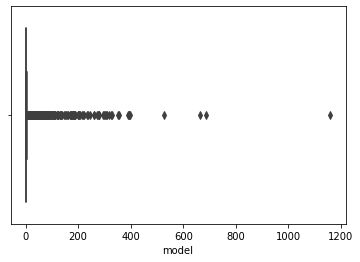

In [18]:
# viz model distribution
sns.boxplot(model_count)

Model seems to be a useful field, but being a free text input seems to contain a lot of extraneous values. So, we can define a threshold of counter for which the model field is considered valid, else we can consider the model field invalid. We can introduce a new column ('is_model_valid') for the same.

This can potentially be tacled as part of Task 3 (Feature Engineering), so we will drop the feature for now.

In [0]:
irrelevant_features.append('model')

In [0]:
# Image URL and description have very high cardinality, so removing them.
irrelevant_features.extend(['image_url', 'description'])

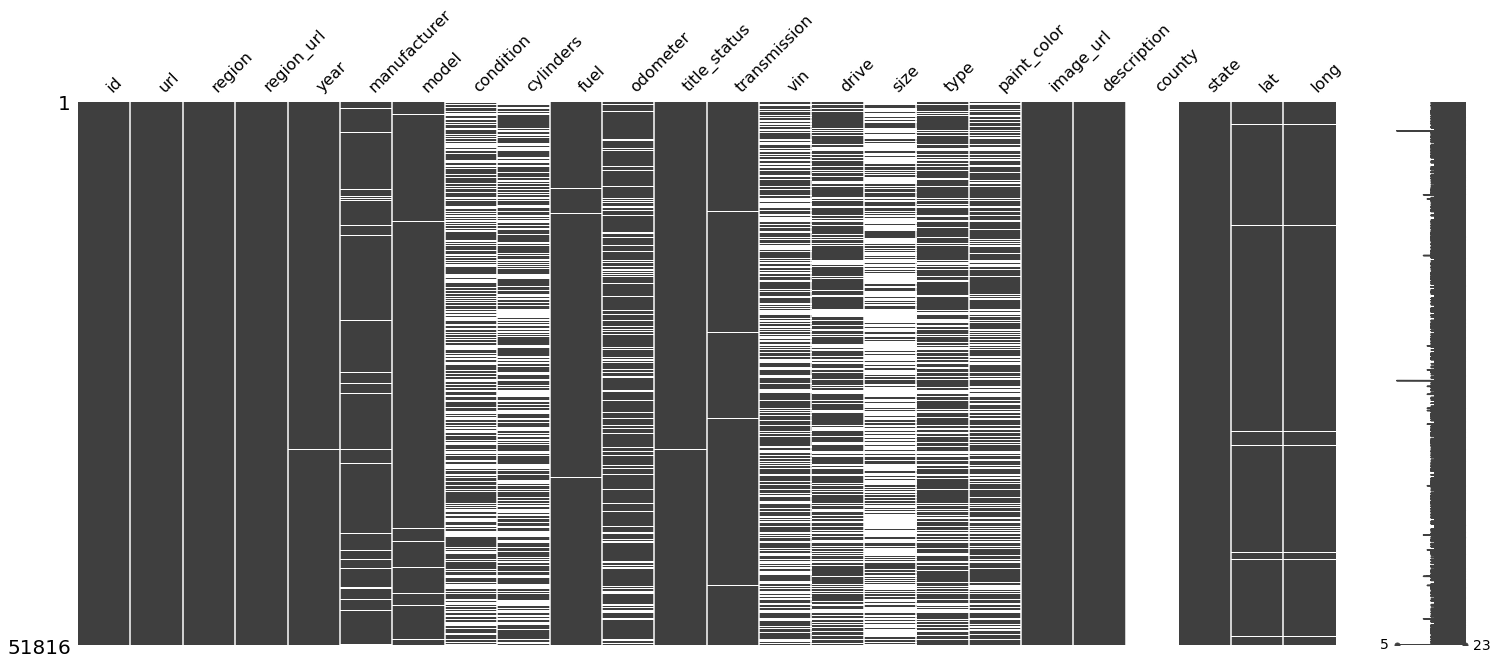

In [21]:
msno.matrix(X_viz)
plt.show()

In [22]:
percent_na = 100*X_viz.isna().sum()/X_viz.shape[0]
print (percent_na)

id                0.000000
url               0.000000
region            0.000000
region_url        0.000000
year              0.204570
manufacturer      4.353868
model             1.470588
condition        43.884128
cylinders        40.674695
fuel              0.681257
odometer         18.507797
title_status      0.567392
transmission      0.723715
vin              41.452447
drive            29.131928
size             69.096418
type             27.354485
paint_color      32.501544
image_url         0.005790
description       0.005790
county          100.000000
state             0.000000
lat               1.729196
long              1.729196
dtype: float64


In [0]:
# We see that almost 70% data is missing for the size parameter, thus removing the feature
# As the imputations can lead to new trends being introduced instead.
irrelevant_features.append('size')

In [24]:
irrelevant_features

['county',
 'id',
 'url',
 'vin',
 'region_url',
 'model',
 'image_url',
 'description',
 'size']

In [25]:
relevant_features = [col for col in X_viz.columns if col not in irrelevant_features]
print ('Relevant features:', relevant_features)


Relevant features: ['region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'lat', 'long']


In [0]:
def retain_relevant_features(df, relevant_feature_list=None, irrelevant_feature_list=None):
    """
    Utility mothod to retain relevant features or
    remove irrelevant features from the given dataframe.
    """
    if relevant_feature_list is not None:
        df = df[relevant_feature_list]
    elif irrelevant_feature_list is not None:
        rf_list = [col for col in X.columns if col not in irrelevant_feature_list]
        df = df[rf_list]
    return df

X_viz = retain_relevant_features(X_viz, relevant_feature_list=relevant_features)

In [27]:
X_viz.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
191449,eau claire,2007.0,ford,excellent,4 cylinders,gas,117.0,clean,automatic,4wd,SUV,blue,wi,44.7684,-91.2856
447630,winchester,2010.0,honda,excellent,4 cylinders,gas,NaN,clean,automatic,4wd,NaN,NaN,va,38.8405,-77.8911
180717,ocala,2017.0,hyundai,good,NaN,gas,26627.0,clean,automatic,NaN,SUV,silver,fl,33.7865,-84.4454
326293,inland empire,2011.0,chevrolet,excellent,4 cylinders,gas,51397.0,clean,automatic,rwd,truck,black,ca,33.8756,-117.5700
469132,"st louis, MO",2015.0,chevrolet,NaN,NaN,gas,98707.0,clean,automatic,4wd,pickup,brown,il,38.7170,-90.3626


#### Target leaking columns


Sometimes description contains the price of the vehicle as part of the free text field. This can possibly leak the target information.

## Task 2: Preprocessing and Baseline model

#### Outlier treatment

In [28]:
def get_cont_and_cat(df):
    """
    Splits given dataframe into continuous and categorical variables.
    """
    cont_features = df.dtypes != np.object
    cont = [col for col in df.columns if df[col].dtype != np.object]
    cat = [col for col in df.columns if df[col].dtype == np.object]
    return cont, cat

continuous, categorical = get_cont_and_cat(X_viz)
print ('continuous:', continuous)
print ('categorical:', categorical)

continuous: ['year', 'odometer', 'lat', 'long']
categorical: ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']


In [29]:
X_viz.isna().sum()

region              0
year              106
manufacturer     2256
condition       22739
cylinders       21076
fuel              353
odometer         9590
title_status      294
transmission      375
drive           15095
type            14174
paint_color     16841
state               0
lat               896
long              896
dtype: int64

In [30]:
print ('Odometer NA count', X_viz.odometer.isna().sum())
print ('Year NA count', X_viz.year.isna().sum())
print ('Lat NA count', X_viz.lat.isna().sum())
print ('Long NA count', X_viz.long.isna().sum())
print ('Price NA count', y_viz.price.isna().sum())

Odometer NA count 9590
Year NA count 106
Lat NA count 896
Long NA count 896
Price NA count 0


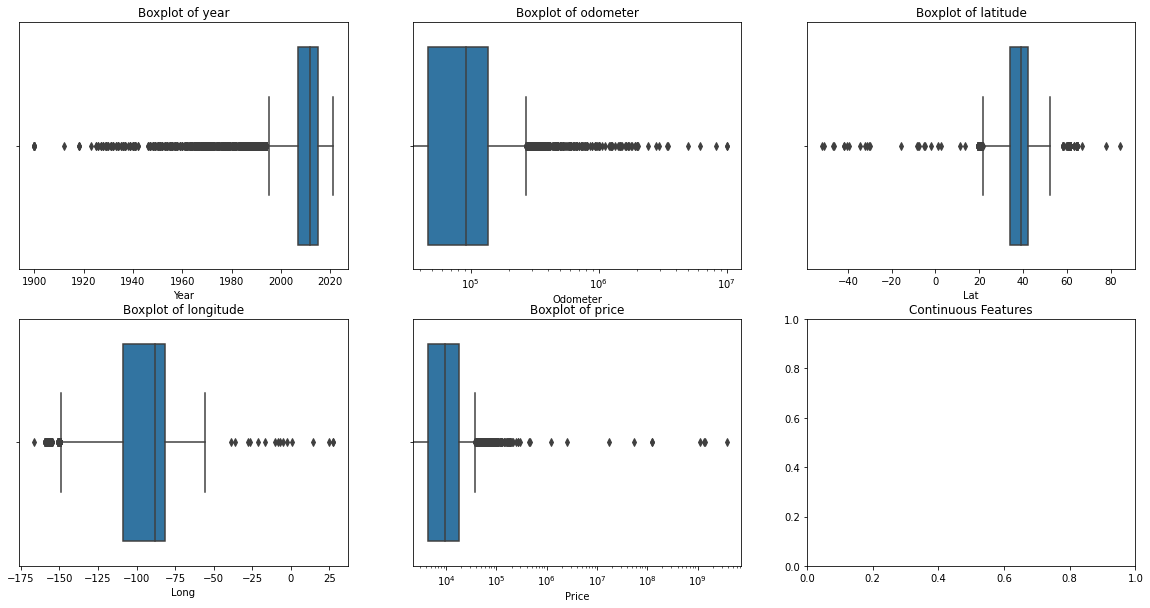

In [31]:
# Visualizing continuous variables
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

plt.title("Continuous Features")
ax = sns.boxplot(X_viz.year, ax=axes[0][0])
ax.set(title='Boxplot of year', xlabel='Year')

ax = sns.boxplot(X_viz.odometer, ax=axes[0][1])
ax.set(title='Boxplot of odometer', xlabel='Odometer')
ax.set_xscale("log")

ax = sns.boxplot(X_viz.lat, ax=axes[0][2])
ax.set(title='Boxplot of latitude', xlabel='Lat')

ax = sns.boxplot(X_viz.long, ax=axes[1][0])
ax.set(title='Boxplot of longitude', xlabel='Long')

ax = sns.boxplot(y_viz.price, ax=axes[1][1])
ax.set(title='Boxplot of price', xlabel='Price')
ax.set_xscale("log")

plt.show()

In [32]:
print('Outliers at Either Extreme')
print('Year 1%ile: ', X_viz.quantile(0.01)['year'])
print('Odometer 99.5%ile: ', X_viz.quantile(0.99)['odometer'])
print('Price 99.5%ile: ', y_viz.quantile(0.995)['price'])

Outliers at Either Extreme
Year 1%ile:  1969.0
Odometer 99.5%ile:  272000.0
Price 99.5%ile:  61998.70000000001


In [0]:
def remove_outliers(df, X_quantile, y_quantile):
    """
    Remove outliers from the given dataframe using the X and y quantiles/
    Also removes all data points with price = 0.
    """
    df_outlier_treated = df[sampled_df.price <= y_quantile.quantile(0.995)['price']]
    df_outlier_treated = df_outlier_treated[df_outlier_treated.price != 0]
    df_outlier_treated = df_outlier_treated[
        (df_outlier_treated.odometer <= X_quantile.quantile(0.99)['odometer']) |
        (pd.isna(df_outlier_treated.odometer))
    ]
    df_outlier_treated = df_outlier_treated[
        df_outlier_treated.year >= X_quantile.quantile(0.01)['year']
    ]
    return df_outlier_treated

sampled_df_outlier_treated = remove_outliers(sampled_df, X_viz, y_viz)

#### Univariate distribution of continuous variables.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


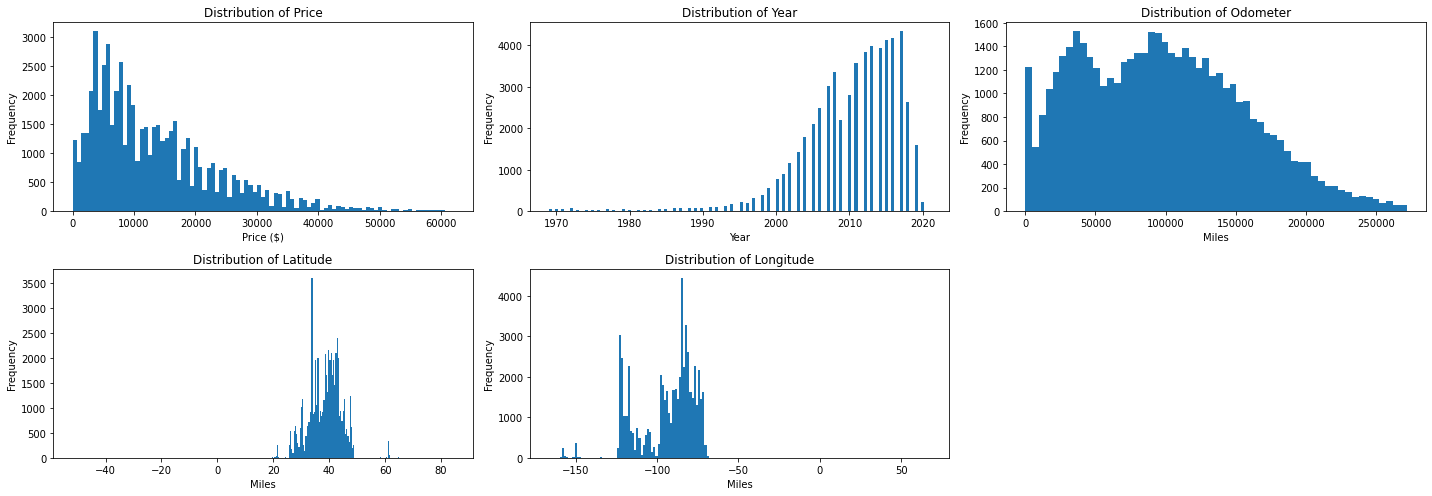

In [34]:
# Univariate distribution of continuous variables
fig, axes = plt.subplots(2, 3, figsize=(20,7))

axes[0][0].hist(sampled_df_outlier_treated.price, bins='auto')
axes[0][0].set(title='Distribution of Price', xlabel='Price ($)', ylabel='Frequency')

axes[0][1].hist(sampled_df_outlier_treated.year, bins='auto')
axes[0][1].set(title='Distribution of Year', xlabel='Year', ylabel='Frequency')

axes[0][2].hist(sampled_df_outlier_treated.odometer, bins='auto')
axes[0][2].set(title='Distribution of Odometer', xlabel='Miles', ylabel='Frequency')

axes[1][0].hist(sampled_df_outlier_treated.lat, bins='auto')
axes[1][0].set(title='Distribution of Latitude', xlabel='Miles', ylabel='Frequency')

axes[1][1].hist(sampled_df_outlier_treated.long, bins='auto')
axes[1][1].set(title='Distribution of Longitude', xlabel='Miles', ylabel='Frequency')


fig.delaxes(axes[1][2])

plt.tight_layout()

The distributions of the continuous and the target variables seem to be conforming to a relatively normal distribution. The target is not heavily skewed, thus we can skip any transformations to the data space.

In [0]:
X, y = split_into_x_and_y(sampled_df_outlier_treated)
X = retain_relevant_features(X, relevant_feature_list=relevant_features)

In [36]:
X.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
271953,worcester / central MA,2010.0,bmw,NaN,6 cylinders,gas,99294.0,clean,automatic,rwd,SUV,blue,ma,42.24760,-71.7273
489985,lexington,2004.0,chevrolet,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ky,-1.98472,-76.1669
70712,new haven,2006.0,chevrolet,good,8 cylinders,diesel,138000.0,clean,automatic,4wd,pickup,white,ct,37.13280,-95.7856
135235,phoenix,2012.0,kia,NaN,4 cylinders,gas,98274.0,clean,automatic,fwd,sedan,custom,az,33.27230,-111.8340
477912,indianapolis,2016.0,ford,NaN,NaN,diesel,178722.0,clean,automatic,4wd,other,white,in,39.82110,-88.8793


In [37]:
X.shape

(57717, 15)

#### Imputation

In [0]:
# Create train/test split for baseline.
(X_train_baseline,
 X_test_baseline,
 y_train_baseline,
 y_test_baseline) = get_train_test_split(X=None, y=None, df=sampled_df_outlier_treated)
X_train_baseline = retain_relevant_features(X_train_baseline,
                                            relevant_feature_list=relevant_features)
X_test_baseline = retain_relevant_features(X_test_baseline,
                                           relevant_feature_list=relevant_features)

In [39]:
X_train_baseline.nunique()

region            401
year               53
manufacturer       41
condition           6
cylinders           8
fuel                5
odometer        24060
title_status        6
transmission        3
drive               3
type               13
paint_color        12
state              51
lat             15037
long            14714
dtype: int64

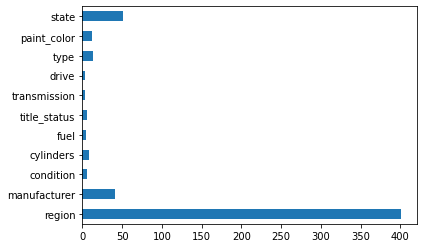

In [40]:
X_train_baseline.nunique().drop(continuous).plot.barh()
plt.show()

In [41]:
# Checking for ordinal and one-hot encoding.
print ('Manufacturer unique values', X_train_baseline.manufacturer.unique())
print ('Condition unique values', X_train_baseline.condition.unique())
print ('Cylinders unique values', X_train_baseline.cylinders.unique())
print ('Fuel unique values', X_train_baseline.fuel.unique())
print ('Title status unique values', X_train_baseline.title_status.unique())
print ('Transmission unique values', X_train_baseline.transmission.unique())
print ('Drive unique values', X_train_baseline.drive.unique())
print ('Type unique values', X_train_baseline['type'].unique())
print ('Paint color unique values', X_train_baseline['paint_color'].unique())
print ('State unique values', X_train_baseline['state'].unique())

Manufacturer unique values ['toyota' 'ford' 'chevrolet' 'volvo' 'jeep' 'ram' 'hyundai' 'honda' 'gmc'
 'dodge' 'volkswagen' 'mazda' 'kia' 'nissan' 'jaguar' 'buick'
 'mercedes-benz' 'pontiac' 'bmw' 'mini' nan 'mitsubishi' 'subaru'
 'chrysler' 'lexus' 'cadillac' 'audi' 'lincoln' 'acura' 'infiniti'
 'mercury' 'saturn' 'rover' 'tesla' 'fiat' 'harley-davidson' 'alfa-romeo'
 'land rover' 'ferrari' 'porche' 'datsun' 'aston-martin']
Condition unique values [nan 'like new' 'good' 'excellent' 'new' 'fair' 'salvage']
Cylinders unique values [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' '3 cylinders'
 'other' '10 cylinders' '12 cylinders']
Fuel unique values ['gas' 'diesel' nan 'other' 'hybrid' 'electric']
Title status unique values ['clean' 'lien' 'salvage' 'rebuilt' 'missing' nan 'parts only']
Transmission unique values ['automatic' 'manual' 'other' nan]
Drive unique values ['4wd' nan 'fwd' 'rwd']
Type unique values [nan 'truck' 'other' 'sedan' 'wagon' 'SUV' 'convertible' 'pickup' 

- A missing manufacturer cannot be simply imputed with the most common one as it can be any manufacturer both within our set and outside the set as well. So, we will add a missing indicator.
- A missing type cannot be imputed as well because the inputs are varying and can be within or outside the set. So, we will add a missing indicator.
- Imputing the two features above (manufacturer and type) with "other" in the imputer.
- Imputing the other categorical variables with the most frequent term.
- Imputing the continuous variables with the mean value.

In [0]:
def get_base_imputer(cont_cols):
    """
    Returns a base imputer using MissingIndicator and simple imputation.
    """
    base_imputer = make_column_transformer(
        (MissingIndicator(), ['manufacturer', 'type']),
        (SimpleImputer(strategy='constant', fill_value='other'), ['manufacturer',
                                                                  'type']),
        (SimpleImputer(strategy='most_frequent'), ['condition',
                                                   'fuel',
                                                   'title_status',
                                                   'transmission',
                                                   'cylinders',
                                                   'paint_color',
                                                   'drive']),
        (SimpleImputer(strategy='mean'), cont_cols),
        remainder = 'passthrough'
    )
    return base_imputer

In [0]:
imputer = get_base_imputer(continuous)
X_train_baseline = imputer.fit_transform(X_train_baseline)

In [44]:
X_train_baseline[:5]

array([[False, True, 'toyota', 'other', 'excellent', 'gas', 'clean',
        'automatic', '6 cylinders', 'white', '4wd', 2008.0, 134934.0,
        48.9372, -122.459, 'bellingham', 'wa'],
       [False, True, 'ford', 'other', 'excellent', 'gas', 'clean',
        'automatic', '6 cylinders', 'white', '4wd', 2008.0, 114296.0,
        43.1867, -84.1639, 'grand rapids', 'mi'],
       [False, False, 'chevrolet', 'truck', 'like new', 'gas', 'clean',
        'automatic', '8 cylinders', 'silver', '4wd', 2015.0,
        98064.87898743514, 35.199, -97.4841, 'wichita', 'ks'],
       [False, True, 'ford', 'other', 'excellent', 'gas', 'clean',
        'automatic', '6 cylinders', 'white', '4wd', 2005.0,
        98064.87898743514, 36.06, -90.5251, 'jonesboro', 'ar'],
       [False, True, 'volvo', 'other', 'excellent', 'diesel', 'clean',
        'manual', '6 cylinders', 'white', '4wd', 1989.0,
        98064.87898743514, 46.8563, -114.025, 'helena', 'mt']],
      dtype=object)

In [0]:
def get_base_imputer_column_order(imputer, extra_cols=None):
    """
    Gets column order for the base imputer
    """
    if extra_cols is None:
        extra_cols = []
    imputer_column_order = (['isna_' + x for x in imputer.transformers[0][2]] +
                             imputer.transformers[1][2] +
                             imputer.transformers[2][2] +
                             imputer.transformers[3][2] +
                             extra_cols)
    return imputer_column_order

X_train_baseline = pd.DataFrame(
    X_train_baseline,
    columns=get_base_imputer_column_order(imputer, ['state', 'region'])
)

In [46]:
X_train_baseline.isna().sum()

isna_manufacturer    0
isna_type            0
manufacturer         0
type                 0
condition            0
fuel                 0
title_status         0
transmission         0
cylinders            0
paint_color          0
drive                0
year                 0
odometer             0
lat                  0
long                 0
state                0
region               0
dtype: int64

In [0]:
def get_base_preprocessor(cont_cols, cond_order, one_hot_encoding_list=None, target_encoding_list=None):
    """
    Gets a preprocessor which does StandardScaling on continuous features,
    Ordinal encoding on the condition variable and
    One-hot encoding for categorical features.
    """
    if one_hot_encoding_list is None:
        one_hot_encoding_list = []
    if target_encoding_list is None:
        target_encoding_list = []
    base_preprocessor = make_column_transformer(
        (StandardScaler(), cont_cols),
        (OrdinalEncoder(categories=[np.array(cond_order, dtype='object')]), ['condition']),
        (ce.target_encoder.TargetEncoder(handle_missing='value',
                                         handle_unknown='value'), target_encoding_list),
        (OneHotEncoder(handle_unknown='ignore'), one_hot_encoding_list),
        remainder = 'passthrough'
    )
    return base_preprocessor

We have done Target Encoding on two of the categorical features with high cardinality. We can TargetEncode others if needed.

In [0]:
condition_order = ['salvage', 
                   'fair',
                   'good',
                   'excellent',
                   'like new',
                   'new']

base_one_hot_encoding_list =  ['fuel',
                               'title_status',
                               'transmission',
                               'drive',
                               'cylinders',
                               'type',
                               'state',
                               'manufacturer']

base_target_encoding_list = ['region',
                             'paint_color']

preprocess = get_base_preprocessor(continuous,
                                   condition_order,
                                   one_hot_encoding_list=base_one_hot_encoding_list,
                                   target_encoding_list=base_target_encoding_list)

In [0]:
def linear_model_with_preprocessing(preprocess_transformer,
                                    linear_model,
                                    X_train_inst,
                                    y_train_inst,
                                    model_name):
    """
    Utility method to run a linear model with the given preprocessor
    and print cross validation score.
    """
    scorer = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    pipe = make_pipeline(preprocess_transformer, linear_model)
    pipe_score = cross_validate(pipe,
                                X_train_inst,
                                y_train_inst,
                                cv=10,
                                scoring=scorer)
    results = ['Baseline ({0})'.format(model_name),
               -np.mean(pipe_score['test_rmse']),
               np.mean(pipe_score['test_r2'])]
    print('Baseline ({0}) R-Squared: '.format(model_name),
          round(np.mean(pipe_score['test_r2']), 4))
    print('Baseline ({0}) RMSE: '.format(model_name),
          round(-np.mean(pipe_score['test_rmse']), 4))

In [50]:
linear_model_with_preprocessing(preprocess,
                                LinearRegression(),
                                X_train_baseline,
                                y_train_baseline,
                                'Linear regression')

Baseline (Linear regression) R-Squared:  0.5784
Baseline (Linear regression) RMSE:  6664.8984


In [51]:
linear_model_with_preprocessing(preprocess,
                                Ridge(),
                                X_train_baseline,
                                y_train_baseline,
                                'Ridge')

Baseline (Ridge) R-Squared:  0.5689
Baseline (Ridge) RMSE:  6740.4318


From the above experiments we can see that our baseline revolves around 0.57 R-squared and 6700 RMSE.

## Task 3: Feature Engineering

#### Polynomial Features

In [0]:
(X_train_fe_poly,
 X_test_fe_poly,
 y_train_fe_poly,
 y_test_fe_poly) = get_train_test_split(X=None, y=None, df=sampled_df_outlier_treated)
X_train_fe_poly = retain_relevant_features(X_train_fe_poly,
                                           relevant_feature_list=relevant_features)
X_test_fe_poly = retain_relevant_features(X_test_fe_poly,
                                          relevant_feature_list=relevant_features)

In [53]:
X_train_fe_poly.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
251002,bellingham,2008.0,toyota,NaN,NaN,gas,134934.0,clean,automatic,4wd,NaN,NaN,wa,48.9372,-122.4590
251332,grand rapids,2008.0,ford,NaN,NaN,gas,114296.0,clean,automatic,NaN,NaN,NaN,mi,43.1867,-84.1639
262545,wichita,2015.0,chevrolet,like new,8 cylinders,gas,NaN,clean,automatic,4wd,truck,silver,ks,35.1990,-97.4841
448362,jonesboro,2005.0,ford,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ar,36.0600,-90.5251
431487,helena,1989.0,volvo,NaN,NaN,diesel,NaN,clean,manual,NaN,NaN,NaN,mt,46.8563,-114.0250


In [54]:
imputer = get_base_imputer(continuous)
X_train_fe_poly = imputer.fit_transform(X_train_fe_poly)
X_train_fe_poly = pd.DataFrame(
    X_train_fe_poly,
    columns=get_base_imputer_column_order(imputer, ['state', 'region'])
)
X_train_fe_poly.head()

,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,lat,long,state,region
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,134934,48.9372,-122.459,bellingham,wa
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,114296,43.1867,-84.1639,grand rapids,mi
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,2015,98064.9,35.199,-97.4841,wichita,ks
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2005,98064.9,36.06,-90.5251,jonesboro,ar
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,1989,98064.9,46.8563,-114.025,helena,mt


In [0]:
def run_standard_scaler(df, col_names=None):
    """
    Run standard scaler on the given columns of the dataframe.
    """
    if col_names is None:
        col_names = []
    scaler = StandardScaler()
    df[col_names] = scaler.fit_transform(df[col_names])
    return df

In [0]:
X_train_fe_poly = run_standard_scaler(X_train_fe_poly,
                                      col_names=['year', 'odometer', 'lat', 'long'])

In [57]:
X_train_fe_poly.head()

,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,lat,long,state,region
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.698841,1.74725,-1.62511,bellingham,wa
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.307655,0.784527,0.556004,grand rapids,mi
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,0.705194,0,-0.552746,-0.202654,wichita,ks
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.742138,0,-0.4086,0.193699,jonesboro,ar
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,-3.05787,0,1.39888,-1.14475,helena,mt


In [0]:
def add_poly_features(df, cols=[]):
    """
    Add polynomial features to the dataframe from the given columns.
    """
    new_cols_added = []
    
    # Addd squared terms.
    for col in cols:
        df[col + '^2'] = df[col] ** 2
        new_cols_added.append(col + '^2')
    
    # Add cross-terms.
    for subset in itertools.combinations(cols, 2):
        col1, col2 = subset[0], subset[1]
        new_col_name = '{0}-{1}'.format(str(col1), str(col2))
        new_cols_added.append(new_col_name)
        df[new_col_name] = df[col1] * df[col2]

    return df, new_cols_added

In [59]:
X_train_fe_poly, new_cols_added = add_poly_features(X_train_fe_poly, cols=continuous)
print (new_cols_added)
for col in (continuous + new_cols_added):
    X_train_fe_poly = X_train_fe_poly.astype({col: 'float64'})
X_train_fe_poly.head()

['year^2', 'odometer^2', 'lat^2', 'long^2', 'year-odometer', 'year-lat', 'year-long', 'odometer-lat', 'odometer-long', 'lat-long']


,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,lat,long,state,region,year^2,odometer^2,lat^2,long^2,year-odometer,year-lat,year-long,odometer-lat,odometer-long,lat-long
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.698841,1.747255,-1.625113,bellingham,wa,0.094826,0.488379,3.052900,2.640991,-0.215200,-0.538047,0.500435,1.221054,-1.135695,-2.839486
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.307655,0.784527,0.556004,grand rapids,mi,0.094826,0.094652,0.615482,0.309141,-0.094739,-0.241586,-0.171215,0.241364,0.171058,0.436200
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,0.705194,0.000000,-0.552746,-0.202654,wichita,ks,0.497298,0.000000,0.305528,0.041069,0.000000,-0.389793,-0.142911,-0.000000,-0.000000,0.112016
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.742138,0.000000,-0.408600,0.193699,jonesboro,ar,0.550769,0.000000,0.166954,0.037519,-0.000000,0.303238,-0.143751,-0.000000,0.000000,-0.079145
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,-3.057869,0.000000,1.398878,-1.144750,helena,mt,9.350560,0.000000,1.956860,1.310452,-0.000000,-4.277585,3.500495,0.000000,-0.000000,-1.601365


In [0]:
continuous_poly, categorical_poly = get_cont_and_cat(X_train_fe_poly)

In [61]:
print ('Continuous:', continuous_poly)
print ('Categorical:', categorical_poly)

Continuous: ['year', 'odometer', 'lat', 'long', 'year^2', 'odometer^2', 'lat^2', 'long^2', 'year-odometer', 'year-lat', 'year-long', 'odometer-lat', 'odometer-long', 'lat-long']
Categorical: ['isna_manufacturer', 'isna_type', 'manufacturer', 'type', 'condition', 'fuel', 'title_status', 'transmission', 'cylinders', 'paint_color', 'drive', 'state', 'region']


In [0]:
def get_imputer_poly(cont_cols):
    """
    Polynomial imputer to avoid nans after polynomial features are added.
    """
    imputer_p = make_column_transformer(
        (SimpleImputer(strategy='mean'), cont_cols),
        remainder = 'passthrough'
    )
    return imputer_p

In [0]:
def get_imputer_poly_column_order(imputer_p, cont_feature_list=None, cat_feature_list=None):
    """
    Get column order coming out of the polynomial imputer.
    """
    if cont_feature_list is None:
        cont_feature_list = []
    if cat_feature_list is None:
        cat_feature_list = []
    imputer_poly_column_order = (cont_feature_list +
                                 cat_feature_list)
    return imputer_poly_column_order

In [0]:
cat_feature_list_poly = [
    'isna_manufacturer',
    'isna_type',
    'manufacturer',
    'type',
    'condition',
    'fuel',
    'title_status',
    'transmission',
    'cylinders',
    'paint_color',
    'drive',
    'state',
    'region'
]

In [65]:
imputer_poly = get_imputer_poly(continuous_poly)
X_train_fe_poly = imputer_poly.fit_transform(X_train_fe_poly)
X_train_fe_poly = pd.DataFrame(
    X_train_fe_poly,
    columns=get_imputer_poly_column_order(imputer_poly,
                                          cont_feature_list=continuous_poly,
                                          cat_feature_list=cat_feature_list_poly)
)
X_train_fe_poly.head()

,year,odometer,lat,long,year^2,odometer^2,lat^2,long^2,year-odometer,year-lat,year-long,odometer-lat,odometer-long,lat-long,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,state,region
0,-0.307938,0.698841,1.74725,-1.62511,0.0948261,0.488379,3.0529,2.64099,-0.2152,-0.538047,0.500435,1.22105,-1.1357,-2.83949,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,bellingham,wa
1,-0.307938,0.307655,0.784527,0.556004,0.0948261,0.0946517,0.615482,0.309141,-0.0947388,-0.241586,-0.171215,0.241364,0.171058,0.4362,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,grand rapids,mi
2,0.705194,0,-0.552746,-0.202654,0.497298,0,0.305528,0.0410688,0,-0.389793,-0.142911,-0,-0,0.112016,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,wichita,ks
3,-0.742138,0,-0.4086,0.193699,0.550769,0,0.166954,0.0375193,-0,0.303238,-0.143751,-0,0,-0.0791455,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,jonesboro,ar
4,-3.05787,0,1.39888,-1.14475,9.35056,0,1.95686,1.31045,-0,-4.27759,3.50049,0,-0,-1.60137,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,helena,mt


In [0]:
preprocess_poly = get_base_preprocessor(continuous_poly,
                                        condition_order,
                                        one_hot_encoding_list=base_one_hot_encoding_list,
                                        target_encoding_list=base_target_encoding_list)

In [67]:
linear_model_with_preprocessing(preprocess_poly,
                                LinearRegression(),
                                X_train_fe_poly,
                                y_train_fe_poly,
                                'Linear regression')

Baseline (Linear regression) R-Squared:  0.6493
Baseline (Linear regression) RMSE:  6078.5892


In [68]:
linear_model_with_preprocessing(preprocess_poly,
                                Ridge(),
                                X_train_fe_poly,
                                y_train_fe_poly,
                                'Ridge')

Baseline (Ridge) R-Squared:  0.6432
Baseline (Ridge) RMSE:  6131.9123


#### Geohashing of lat long

In [69]:
sampled_df_for_geohash = sampled_df_outlier_treated.copy(deep=True)
sampled_df_for_geohash['geohash'] = sampled_df_for_geohash.apply(
    lambda x: geo.encode(x.lat, x.long, precision=3),
    axis=1
)
print('Cardinality of "geohash": ', len(set(sampled_df_for_geohash.geohash)))

Cardinality of "geohash":  463


In [0]:
sampled_df_for_geohash.drop(['lat', 'long'], axis=1, inplace=True)

In [0]:
(X_train_fe_geohash,
 X_test_fe_geohash,
 y_train_fe_geohash,
 y_test_fe_geohash) = get_train_test_split(X=None, y=None, df=sampled_df_for_geohash)
relevant_features_fe_geohash = [r for r in relevant_features if r not in ['lat', 'long']]
relevant_features_fe_geohash.append('geohash')
X_train_fe_geohash = retain_relevant_features(X_train_fe_geohash,
                                              relevant_feature_list=relevant_features_fe_geohash)
X_test_fe_geohash = retain_relevant_features(X_test_fe_geohash,
                                             relevant_feature_list=relevant_features_fe_geohash)

In [72]:
X_train_fe_geohash.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,geohash
251002,bellingham,2008.0,toyota,NaN,NaN,gas,134934.0,clean,automatic,4wd,NaN,NaN,wa,c28
251332,grand rapids,2008.0,ford,NaN,NaN,gas,114296.0,clean,automatic,NaN,NaN,NaN,mi,dps
262545,wichita,2015.0,chevrolet,like new,8 cylinders,gas,NaN,clean,automatic,4wd,truck,silver,ks,9y6
448362,jonesboro,2005.0,ford,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ar,9yr
431487,helena,1989.0,volvo,NaN,NaN,diesel,NaN,clean,manual,NaN,NaN,NaN,mt,c2q


In [73]:
X_train_fe_geohash.isna().sum()

region              0
year                0
manufacturer     1698
condition       19351
cylinders       18529
fuel              255
odometer         8210
title_status      209
transmission      294
drive           13457
type            12757
paint_color     14852
state               0
geohash             0
dtype: int64

As there are no NaNs in the geohash column, we can skip imputation for the same.

In [74]:
continuous_geohash, categorical_geohash = get_cont_and_cat(X_train_fe_geohash)
print ('continuous_geohash', continuous_geohash)
print ('categorical_geohash', categorical_geohash)

continuous_geohash ['year', 'odometer']
categorical_geohash ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'geohash']


In [75]:
imputer = get_base_imputer(continuous_geohash)
X_train_fe_geohash = imputer.fit_transform(X_train_fe_geohash)
X_train_fe_geohash = pd.DataFrame(
    X_train_fe_geohash,
    columns=get_base_imputer_column_order(imputer,
                                          ['state', 'region', 'geohash'])
)
X_train_fe_geohash.head()

,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,state,region,geohash
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,134934,bellingham,wa,c28
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,114296,grand rapids,mi,dps
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,2015,98064.9,wichita,ks,9y6
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2005,98064.9,jonesboro,ar,9yr
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,1989,98064.9,helena,mt,c2q


In [76]:
X_train_fe_geohash.isna().sum()

isna_manufacturer    0
isna_type            0
manufacturer         0
type                 0
condition            0
fuel                 0
title_status         0
transmission         0
cylinders            0
paint_color          0
drive                0
year                 0
odometer             0
state                0
region               0
geohash              0
dtype: int64

In [77]:
X_train_fe_geohash.head()

,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,state,region,geohash
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,134934,bellingham,wa,c28
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,114296,grand rapids,mi,dps
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,2015,98064.9,wichita,ks,9y6
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2005,98064.9,jonesboro,ar,9yr
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,1989,98064.9,helena,mt,c2q


In [0]:
geohash_one_hot_encoding_list = [oh for oh in base_one_hot_encoding_list]
geohash_one_hot_encoding_list.append('geohash')
preprocess_geohash = get_base_preprocessor(continuous_geohash,
                                           condition_order,
                                           one_hot_encoding_list=geohash_one_hot_encoding_list,
                                           target_encoding_list=base_target_encoding_list)

In [79]:
linear_model_with_preprocessing(preprocess_geohash,
                                LinearRegression(),
                                X_train_fe_geohash,
                                y_train_fe_geohash,
                                'Linear regression')

Baseline (Linear regression) R-Squared:  0.5893
Baseline (Linear regression) RMSE:  6578.5385


In [80]:
linear_model_with_preprocessing(preprocess_geohash,
                                Ridge(),
                                X_train_fe_geohash,
                                y_train_fe_geohash,
                                'Ridge')

Baseline (Ridge) R-Squared:  0.5802
Baseline (Ridge) RMSE:  6651.1575


#### Combining the two features engineered for verification

In [0]:
sampled_df_for_fe_combined = sampled_df_outlier_treated.copy(deep=True)
sampled_df_for_fe_combined['geohash'] = sampled_df_for_fe_combined.apply(
    lambda x: geo.encode(x.lat, x.long, precision=3),
    axis=1
)

In [0]:
sampled_df_for_fe_combined.drop(['lat', 'long'], axis=1, inplace=True)

In [0]:
(X_train_fe_combined,
 X_test_fe_combined,
 y_train_fe_combined,
 y_test_fe_combined) = get_train_test_split(X=None, y=None, df=sampled_df_for_fe_combined)
relevant_features_fe_combined = [r for r in relevant_features if r not in ['lat', 'long']]
relevant_features_fe_combined.append('geohash')
X_train_fe_combined = retain_relevant_features(X_train_fe_combined,
                                               relevant_feature_list=relevant_features_fe_geohash)
X_test_fe_combined = retain_relevant_features(X_test_fe_combined,
                                              relevant_feature_list=relevant_features_fe_geohash)

In [84]:
X_train_fe_combined.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,geohash
251002,bellingham,2008.0,toyota,NaN,NaN,gas,134934.0,clean,automatic,4wd,NaN,NaN,wa,c28
251332,grand rapids,2008.0,ford,NaN,NaN,gas,114296.0,clean,automatic,NaN,NaN,NaN,mi,dps
262545,wichita,2015.0,chevrolet,like new,8 cylinders,gas,NaN,clean,automatic,4wd,truck,silver,ks,9y6
448362,jonesboro,2005.0,ford,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ar,9yr
431487,helena,1989.0,volvo,NaN,NaN,diesel,NaN,clean,manual,NaN,NaN,NaN,mt,c2q


In [85]:
continuous_combined, categorical_combined = get_cont_and_cat(X_train_fe_combined)
print ('continuous_combined', continuous_combined)
print ('categorical_combined', categorical_combined)

continuous_combined ['year', 'odometer']
categorical_combined ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'geohash']


In [86]:
imputer = get_base_imputer(continuous_combined)
X_train_fe_combined = imputer.fit_transform(X_train_fe_combined)
X_train_fe_combined = pd.DataFrame(
    X_train_fe_combined,
    columns=get_base_imputer_column_order(imputer,
                                          ['state', 'region', 'geohash'])
)
X_train_fe_combined.head()

,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,state,region,geohash
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,134934,bellingham,wa,c28
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2008,114296,grand rapids,mi,dps
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,2015,98064.9,wichita,ks,9y6
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,2005,98064.9,jonesboro,ar,9yr
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,1989,98064.9,helena,mt,c2q


In [0]:
X_train_fe_combined = run_standard_scaler(X_train_fe_combined, col_names=['year', 'odometer'])

In [88]:
X_train_fe_combined, new_cols_added = add_poly_features(X_train_fe_combined,
                                                        cols=continuous_combined)
print (new_cols_added)
for col in (continuous_combined + new_cols_added):
    X_train_fe_combined = X_train_fe_combined.astype({col: 'float64'})
X_train_fe_combined.head()

['year^2', 'odometer^2', 'year-odometer']


,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,year,odometer,state,region,geohash,year^2,odometer^2,year-odometer
0,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.698841,bellingham,wa,c28,0.094826,0.488379,-0.215200
1,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.307938,0.307655,grand rapids,mi,dps,0.094826,0.094652,-0.094739
2,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,0.705194,0.000000,wichita,ks,9y6,0.497298,0.000000,0.000000
3,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,-0.742138,0.000000,jonesboro,ar,9yr,0.550769,0.000000,-0.000000
4,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,-3.057869,0.000000,helena,mt,c2q,9.350560,0.000000,-0.000000


In [89]:
continuous_combined, categorical_combined = get_cont_and_cat(X_train_fe_combined)
print ('continuous_combined', continuous_combined)
print ('categorical_combined', categorical_combined)

continuous_combined ['year', 'odometer', 'year^2', 'odometer^2', 'year-odometer']
categorical_combined ['isna_manufacturer', 'isna_type', 'manufacturer', 'type', 'condition', 'fuel', 'title_status', 'transmission', 'cylinders', 'paint_color', 'drive', 'state', 'region', 'geohash']


In [90]:
cat_feature_list_combined = [f for f in cat_feature_list_poly]
cat_feature_list_combined.append('geohash')
imputer_combined = get_imputer_poly(continuous_combined)
X_train_fe_combined = imputer_combined.fit_transform(X_train_fe_combined)
X_train_fe_combined = pd.DataFrame(
    X_train_fe_combined,
    columns=get_imputer_poly_column_order(imputer_combined,
                                          cont_feature_list=continuous_combined,
                                          cat_feature_list=cat_feature_list_combined)
)
X_train_fe_combined.head()

,year,odometer,year^2,odometer^2,year-odometer,isna_manufacturer,isna_type,manufacturer,type,condition,fuel,title_status,transmission,cylinders,paint_color,drive,state,region,geohash
0,-0.307938,0.698841,0.0948261,0.488379,-0.2152,False,True,toyota,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,bellingham,wa,c28
1,-0.307938,0.307655,0.0948261,0.0946517,-0.0947388,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,grand rapids,mi,dps
2,0.705194,0,0.497298,0,0,False,False,chevrolet,truck,like new,gas,clean,automatic,8 cylinders,silver,4wd,wichita,ks,9y6
3,-0.742138,0,0.550769,0,-0,False,True,ford,other,excellent,gas,clean,automatic,6 cylinders,white,4wd,jonesboro,ar,9yr
4,-3.05787,0,9.35056,0,-0,False,True,volvo,other,excellent,diesel,clean,manual,6 cylinders,white,4wd,helena,mt,c2q


In [91]:
X_train_fe_combined.isna().sum()

year                 0
odometer             0
year^2               0
odometer^2           0
year-odometer        0
isna_manufacturer    0
isna_type            0
manufacturer         0
type                 0
condition            0
fuel                 0
title_status         0
transmission         0
cylinders            0
paint_color          0
drive                0
state                0
region               0
geohash              0
dtype: int64

In [0]:
combined_one_hot_encoding_list = [oh for oh in base_one_hot_encoding_list]
combined_one_hot_encoding_list.append('geohash')
preprocess_combined = get_base_preprocessor(continuous_combined,
                                            condition_order,
                                            one_hot_encoding_list=combined_one_hot_encoding_list,
                                            target_encoding_list=base_target_encoding_list)

In [93]:
linear_model_with_preprocessing(preprocess_combined,
                                LinearRegression(),
                                X_train_fe_combined,
                                y_train_fe_combined,
                                'Linear regression')

Baseline (Linear regression) R-Squared:  0.6568
Baseline (Linear regression) RMSE:  6012.4476


In [94]:
linear_model_with_preprocessing(preprocess_combined,
                                Ridge(),
                                X_train_fe_combined,
                                y_train_fe_combined,
                                'Ridge')

Baseline (Ridge) R-Squared:  0.6477
Baseline (Ridge) RMSE:  6093.21


#### Parameter tuning for linear models

In [95]:
linear_model_with_preprocessing(preprocess_combined,
                                RidgeCV(),
                                X_train_fe_combined,
                                y_train_fe_combined,
                                'RidgeCV')

Baseline (RidgeCV) R-Squared:  0.659
Baseline (RidgeCV) RMSE:  5993.4722


We can do more feature engineering by looking at textual features like model which we dropped earlier in the task. This can help us create a stronger baseline for the model.